<a href="https://colab.research.google.com/github/Deep-of-Machine/AI_Academy/blob/main/Problem6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [ ]:
transform_train = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),                            
                                      transforms.RandomCrop(32, padding=4),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(degrees=(-45, 45)),
                                      ])

# (0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)(0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)

In [ ]:
train_dataset = datasets.CIFAR100(root = 'C:/Users/tjgus/OneDrive/바탕 화면/Final_project_coding/data', train = True, download = True, transform = transform_train)

Files already downloaded and verified


In [ ]:
train_dataset

Dataset CIFAR100
    Number of datapoints: 50000
    Root location: C:/Users/tjgus/OneDrive/바탕 화면/Final_project_coding/data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-45.0, 45.0], interpolation=nearest, expand=False, fill=0)
           )

In [ ]:
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [49000, 1000])

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=500, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=500, shuffle=False)

In [ ]:
for mini_batch in train_loader:
    first_batch = mini_batch
    break

images = first_batch[0]
labels = first_batch[1]

In [ ]:
print(len(train_dataset))
print(len(val_dataset))

49000
1000


In [ ]:
images.shape, labels.shape

(torch.Size([500, 3, 32, 32]), torch.Size([500]))

In [ ]:
images[0].shape

torch.Size([3, 32, 32])

In [ ]:
images[0].numpy().shape

(3, 32, 32)

In [ ]:
np.transpose(images[0].numpy(), (1,2,0)).shape

(32, 32, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


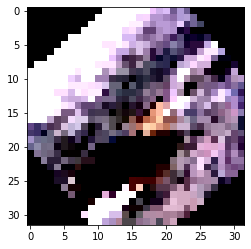

In [ ]:
plt.imshow(np.transpose(images[0].numpy(), (1,2,0)))
plt.show()

In [ ]:
def conv3x3(in_planes, out_planes, stride=1, bias=False):
  """3x3 convolution with padding"""
  return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                   padding=1, bias=bias)

def variable_init(m, neg_slope=0.0):
  if isinstance(m, (nn.Linear, nn.Conv2d)):
    nn.init.kaiming_uniform_(m.weight.data, neg_slope)
    if m.bias is not None:
      m.bias.data.zero_()
  elif isinstance(m, nn.BatchNorm2d):
    if m.weight is not None:
      m.weight.data.fill_(1)
    if m.bias is not None:
      m.bias.data.zero_()
    m.running_mean.zero_()
    m.running_var.zero_()

class PlusMinusOne(object):
  """ Scales values that are between [0, 1] into [-1, 1]. """
  
  def __init__(self):
    pass

  def __call__(self, x):
    x = 2.0 * x - 1.0
    return x    

import torch
import torch.nn as nn

def _down_sample(x):
  return nn.functional.avg_pool2d(x, 2, 2)

def _increase_planes(x, n_out_planes):
  n_samples, n_planes, spatial_size = x.size()[:-1]
  x_zeros = torch.zeros(
    n_samples, n_out_planes - n_planes, spatial_size, spatial_size, 
    dtype=x.dtype, device=x.device)
  return torch.cat([x, x_zeros], 1)

def _downsample_and_increase_planes(x, n_out_planes):
  x = _down_sample(x)
  x = _increase_planes(x, n_out_planes)
  return x

def identity_func(n_in_planes, n_out_planes, stride):
  identity = lambda x: x
  if stride == 2 and n_in_planes != n_out_planes:
    identity = lambda x: _downsample_and_increase_planes(x, n_out_planes)
  elif stride == 2:
    identity = _down_sample
  elif n_in_planes != n_out_planes:
    identity = lambda x: _increase_planes(x, n_out_planes)
  return identity

class BasicBlock(nn.Module):

  expansion = 1

  def __init__(self, n_in_planes, n_out_planes, stride=1):
    super().__init__()
    assert stride == 1 or stride == 2

    self.block = nn.Sequential(
      conv3x3(n_in_planes, n_out_planes, stride),
      nn.BatchNorm2d(n_out_planes),
      nn.ReLU(inplace=True),
      conv3x3(n_out_planes, n_out_planes),
      nn.BatchNorm2d(n_out_planes)
    )

    self.identity = identity_func(n_in_planes, n_out_planes, stride)

  def forward(self, x):
    out = self.block(x)
    identity = self.identity(x)

    out += identity
    out = nn.functional.relu(out)
    return out

class Bottleneck(nn.Module):

  expansion = 4

  def __init__(self, n_in_planes, n_out_planes, stride=1):
    super().__init__()
    
    self.conv1 = nn.Conv2d(n_in_planes, n_out_planes, kernel_size=1)
    self.bn1 = nn.BatchNorm2d(n_out_planes)

    self.conv2 = conv3x3(n_out_planes, n_out_planes, stride)
    self.bn2 = nn.BatchNorm2d(n_out_planes)

    self.conv3 = nn.Conv2d(n_out_planes, n_out_planes * 4, kernel_size=1)
    self.bn3 = nn.BatchNorm2d(n_out_planes * 4)

    self.relu = nn.ReLU(inplace=True)
    self.identity = identity_func(n_in_planes, n_out_planes * 4, stride)

  def forward(self, x):
    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)

    out = self.conv2(out)
    out = self.bn2(out)
    out = self.relu(out)

    out = self.conv3(out)
    out = self.bn3(out)

    identity = self.identity(x)
    out += identity
    out = self.relu(out)

    return out

class ResNet(nn.Module):

  def __init__(self, block, 
                     n_blocks, 
                     n_output_planes, 
                     n_classes):
    super(ResNet, self).__init__()
    assert len(n_blocks) == 4
    assert len(n_output_planes) == 4
    
    self.n_in_planes = n_output_planes[0]

    self.layer0 = nn.Sequential(
      conv3x3(3, self.n_in_planes),
      nn.BatchNorm2d(self.n_in_planes),
      nn.ReLU(inplace=True)
    )
    self.layer1 = self._make_layer(block, n_blocks[0], n_output_planes[0])
    self.layer2 = self._make_layer(block, n_blocks[1], n_output_planes[1], 2)
    self.layer3 = self._make_layer(block, n_blocks[2], n_output_planes[2], 2)
    self.layer4 = self._make_layer(block, n_blocks[3], n_output_planes[3], 2)
    self.fc = nn.Linear(n_output_planes[3] * block.expansion, n_classes, False)

    self.apply(variable_init)

  def _make_layer(self, block, n_blocks, n_out_planes, stride=1):
    layers = []
    layers.append(block(self.n_in_planes, n_out_planes, stride))
    self.n_in_planes = n_out_planes * block.expansion
    for i in range(1, n_blocks):
      layers.append(block(self.n_in_planes, n_out_planes))

    return nn.Sequential(*layers)

  def features(self, x):
    x = self.layer0(x)
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    spatial_size = x.size(2)
    x = nn.functional.max_pool2d(x, spatial_size, 1)
    x = x.view(x.size(0), -1)
    return x

  def forward(self, x):
    x = self.features(x)
    x = self.fc(x)
    return x

def ResNet18():
  return ResNet(BasicBlock, [2,2,2,2], n_output_planes = [64, 128, 256, 512], n_classes = 100)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
model = ResNet18().to(device)

In [ ]:
model(torch.rand(1,3,32, 32).to(device)).shape

torch.Size([1, 100])

In [ ]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total_params)

11046208


In [ ]:
loss_func = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005) # .0.1 momentum=0.9, weight_decay=0.0005
scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer, lr_lambda=lambda epoch: 0.95 ** (epoch+70))
#scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer, lr_lambda=lambda epoch: 0.95 ** (epoch+50))
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)
#ReduceLROnPlateau(optimizer, patience=5, mode='min', verbose=1)
#CosineAnnealingLR(optimizer, T_max=300)       lr 0.1  0.95   epoch 300

In [ ]:
import time
def train():
    model.train()
    start_time = time.time()
    train_loss = 0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        predicted = torch.argmax(outputs, dim = 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    end_time = time.time()

    return train_loss/len(train_loader), 100*correct / total, end_time - start_time

In [ ]:
def validation():
    model.eval()
    start_time = time.time()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_func(outputs, labels)

            val_loss += loss.item()
            predicted = torch.argmax(outputs, dim = 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    end_time = time.time()

    return val_loss/len(val_loader), 100*correct / total, end_time - start_time

In [ ]:
!nvidia-smi

Sat Oct 30 23:33:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 471.68       Driver Version: 471.68       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   39C    P0    22W /  N/A |   4777MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
epochs = 200
max_val_acc = 0

train_losses = []
val_losses = []
train_acces = []
val_acces = []


for epoch in range(epochs):
    train_loss, train_acc, train_time = train()
    print('Epoch : {}, Train loss : {}, acc : {}, time : {}'.format(epoch + 1, train_loss, train_acc, train_time))
    train_losses.append(train_loss)
    train_acces.append(train_acc)
    
    val_loss, val_acc, val_time = validation()
    print('      Validation loss : {}, acc : {}, time : {}'.format(val_loss, val_acc, val_time))
    val_losses.append(val_loss)
    val_acces.append(val_acc)
    
    scheduler.step()
    
    if val_acc >= max_val_acc: # 가장 평가 성능이 좋은 모델을 저장
        PATH = f'C:/Users/tjgus/OneDrive/바탕 화면/Final_project_coding/model/ResNet18_2_{val_acc}.pth'
        torch.save(model.state_dict(), PATH)
        max_val_acc = val_acc

Epoch : 1, Train loss : 0.20520318710074134, acc : 95.50816326530612, time : 74.27892231941223
      Validation loss : 0.1874120980501175, acc : 96.3, time : 0.8222272396087646
Epoch : 2, Train loss : 0.18561081314573483, acc : 95.75714285714285, time : 73.8560574054718
      Validation loss : 0.1696927398443222, acc : 96.5, time : 0.8352878093719482
Epoch : 3, Train loss : 0.1766903757744906, acc : 96.0265306122449, time : 73.98359847068787
      Validation loss : 0.16587410122156143, acc : 96.3, time : 0.823418140411377
Epoch : 4, Train loss : 0.1745316007611703, acc : 95.92040816326531, time : 76.44818806648254
      Validation loss : 0.15482435375452042, acc : 96.1, time : 0.8821041584014893
Epoch : 5, Train loss : 0.16528199202552132, acc : 96.16938775510204, time : 74.55713415145874
      Validation loss : 0.17200352251529694, acc : 96.2, time : 0.8223483562469482
Epoch : 6, Train loss : 0.16562312864223305, acc : 96.21020408163265, time : 76.2405776977539
      Validation loss :

KeyboardInterrupt: 

In [ ]:
PATH = f'C:/Users/tjgus/OneDrive/바탕 화면/Final_project_coding/model/Last_epoch_{val_acc}.pth'
torch.save(model.state_dict(), PATH)

In [ ]:
PATH = "C:/Users/tjgus/OneDrive/바탕 화면/Final_project_coding/model/Cifar100_ResNet18_2_71.03.pth"
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
test_dataset = datasets.CIFAR100(root = 'C:/Users/tjgus/OneDrive/바탕 화면/Final_project_coding/data./test', train = False, download = True, transform = transform_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Files already downloaded and verified


In [ ]:
for mini_batch in test_loader:
    first_batch = mini_batch
    break

inputs = first_batch[0]
labels = first_batch[1]
model.eval()
outputs = model(inputs.to(device))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


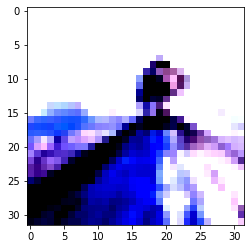

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


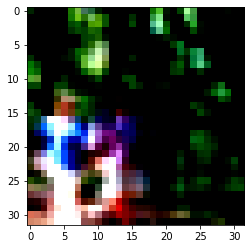

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


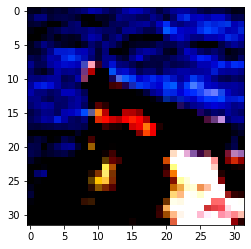

In [ ]:
for i in range(3): 
    sample_number = i

    plt.imshow(np.transpose(inputs[sample_number].numpy(), (1,2,0)))
    plt.show()
    #print('예측 :', classes[torch.argmax(outputs[sample_number]).item()])
    #print('라벨 :', classes[labels[sample_number].item()])

In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        predicted = torch.argmax(outputs, dim = 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(total)
    print(100*correct / total)